In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Set up environment

In [ ]:
# Just delete the output of loading the files because it was very big

import math, re, os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from kaggle_datasets import KaggleDatasets
from tensorflow import keras
from functools import partial
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

##import tensorflow.keras.backend as K

from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, MaxPool2D
from keras.optimizers import SGD
import keras

import h5py

from keras.callbacks import ModelCheckpoint

from keras import metrics


print("Tensorflow version " + tf.__version__)

# Detect TPU
What we're doing with our code here is making sure that we'll be sending our data across a TPU. What you're looking for is a printout of `Number of replicas: 8`, corresponding to the 8 cores of a TPU. If your printout instead says `Number of replicas: 1` you likely do not have TPUs enabled in your notebook.   


In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Device: grpc://10.0.0.2:8470
Number of replicas: 8


# Set up variables
We'll set up some of our variables for our notebook here. 



In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
GCS_PATH = KaggleDatasets().get_gcs_path('cassava-leaf-disease-classification')     

##../input/cassava-leaf-disease-classification

BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [512, 512]
CLASSES = ['0', '1', '2', '3', '4']
LABELS = [0,1,2,3,4]
##EPOCHS = 300
EPOCHS = 300

In [5]:
# No. of batched images for each batch 
BATCH_SIZE

128

In [6]:
# Loading the data file names with labels
df = pd.read_csv(GCS_PATH + '/train.csv')

In [7]:
# Images and Labels
X = df.loc[:,'image_id']
y = df.loc[:,'label']
# getting the values to count each category 
count_labels=y.values

In [8]:
# Counting each types of the 5 labels 

CBB = 0
CBSD = 0
CGM = 0
CMD = 0
Healthy = 0

for label in count_labels:
    if label == 0:
        CBB += 1
    elif label == 1:
        CBSD  += 1
    elif label == 2:
        CGM  += 1
    elif label == 3:
        CMD  += 1
    else:
        Healthy +=1


print("The number of CBB = ",CBB )
print("The number of CBSD = ",CBSD)
print("The number of CGM = ",CGM )
print("The number of CMD = ",CMD)
print("The number of Healthy = ",Healthy)


The number of CBB =  1087
The number of CBSD =  2189
The number of CGM =  2386
The number of CMD =  13158
The number of Healthy =  2577


In [3]:
No_Of_Labels = {'0': 1087, '1': 2189, '2': 2386, '3': 13158, '4': 2577}

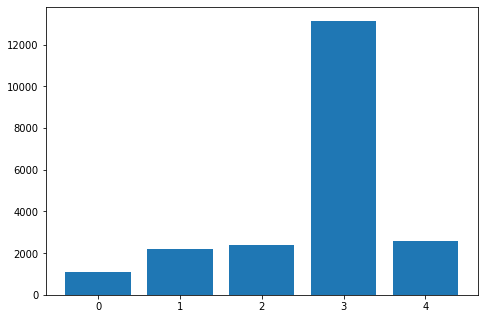

In [4]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(No_Of_Labels.keys(),No_Of_Labels.values())
plt.show()

# Load the data

The data we're working with have been formatted into `TFRecords`, which are a format for storing a sequence of binary records. `TFRecords` work _really_ well with TPUs, and allow us to send a small number of large files across the TPU for processing.  

## Decode the data

In the code chunk below we'll set up a series of functions that allow us to convert our images into tensors so that we can utilize them in our model. We'll also normalize our data. Our images are using a "Red, Blue, Green (RBG)" scale that has a range of [0, 255], and by normalizing it we'll set each pixel's value to a number in the range of [0, 1]. 

## Use the data as soon as it streams in

We'll use the following function to load our dataset. One of the advantages of a TPU is that we can run multiple files across the TPU at once, and this accounts for the speed advantages of using a TPU. To capitalize on that, we want to make sure that we're using data as soon as it streams in, rather than creating a data streaming bottleneck.

In [9]:
## Loading , reading and decoding images from TFRecords

## will be used to load the training data and the validation data

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example, labeled):
    tfrecord_format = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64)
    } if labeled else {
        "image": tf.io.FixedLenFeature([], tf.string),
        "image_name": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    if labeled:
        label = tf.cast(example['target'], tf.int32)
        return image, label
    idnum = example['image_name']
    return image, idnum

def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options() ## Turn off optimization 
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed, ## Turn off optimization (or ordered)
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTOTUNE)
    return dataset

## Adding in augmentations 

Augmentation on the fly using dataset.prefetch(AUTO) after calling data_augment(image, label)

Thanks to the dataset.prefetch(AUTO) statement in the following function this happens essentially for free on TPU. 
Data pipeline code is executed on the "CPU" part of the TPU while the TPU itself is computing gradients.

In [ ]:
## Augmentation on the fly using dataset.prefetch(AUTO) after calling data_augment(image, label)

def data_augment(image, label):
    # Thanks to the dataset.prefetch(AUTO) statement in the following function this happens essentially for free on TPU. 
    # Data pipeline code is executed on the "CPU" part of the TPU while the TPU itself is computing gradients.
    
    ## Manual Augmentation using tf.images library for Augmentation
    
    ## Randomly choose between features to be applied in the Augmentation
    
    choice = np.random.randint(5)
    if choice == 0:
        image = tf.image.flip_left_right(image)
    elif choice == 1:
        image = tf.image.flip_up_down(image)
    elif choice == 2:
        image = tf.image.random_flip_left_right(image)
    elif choice == 3:
        image = tf.image.random_flip_up_down(image)
    else:
        image = tf.image.rot90(image)
    
    ##else:
    ##    return image, label
    
    return image, label

## other features could be applied for Augmentation
'''
elif choice == 5:
        image = tf.image.transpose(image)
    elif choice == 6:
        image = tf.image.adjust_brightness(image, delta=0.1)
    elif choice == 7:
        image = tf.image.adjust_contrast(image, 2)
    elif choice == 8:
        image = tf.image.adjust_gamma(image, 0.2)
    elif choice == 9:
        image = tf.image.random_brightness(image, 0.2)
    elif choice == 10:
        image = tf.image.random_contrast(image, 0.2, 0.5)
    elif choice == 11:
        image = tf.image.rgb_to_grayscale(image)
    else:
        image = tf.image.adjust_hue(image, 0.2)
'''

# Splitting the data

Because our data consists of `training` and `test` images only, we're going to split our `training` data into `training` and `validation` data using the `train_test_split()` function. 

In [14]:
## Splitting the dataset to training and validation 

TRAINING_FILENAMES, VALID_FILENAMES = train_test_split(
    tf.io.gfile.glob(GCS_PATH + '/train_tfrecords/ld_train*.tfrec'),
    test_size=0.1, random_state=5
)

## Loading the test file 

TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test_tfrecords/ld_test*.tfrec')

In [15]:
# Validation filenames to be used in validation offline if needed 
VALID_FILENAMES

['gs://kds-0ec1dec9f628bce2bc810157442805632bd221934a9e1921da420af8/train_tfrecords/ld_train05-1338.tfrec',
 'gs://kds-0ec1dec9f628bce2bc810157442805632bd221934a9e1921da420af8/train_tfrecords/ld_train01-1338.tfrec']

## Define data loading methods
The following functions will be used to load our `training`, `validation`, and `test` datasets, as well as print out the number of images in each dataset.

In [ ]:
## Loading, Augmentation , shuffling batching and prefetching for dataset and call training, validation and testing

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)  
    dataset = dataset.map(data_augment, num_parallel_calls=AUTOTUNE)  ## Augmentation
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048) ## shuffling the dataset 
    dataset = dataset.batch(BATCH_SIZE) ## put the dataset as batches
    dataset = dataset.prefetch(AUTOTUNE) ## used to help Augmentation to be on the fly as we said the Augmentation cell 
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALID_FILENAMES, labeled=True, ordered=ordered)
    ##dataset = dataset.map(data_augment, num_parallel_calls=AUTOTUNE) 
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [17]:
## counting the number of dataset in each category (training and validation)

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALID_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)

print('Dataset: {} training images, {} validation images, {} (unlabeled) test images'.format(
    NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 18721 training images, 2676 validation images, 1 (unlabeled) test images


# Building the model
## Learning rate schedule
We learned about learning rates in the **[Intro to Deep Learning: Stochastic Gradient Descent](https://www.kaggle.com/ryanholbrook/stochastic-gradient-descent)** lesson, and here I've created a learning rate schedule mostly using the defaults in the **[Keras Exponential Decay Learning Rate Scheduler](https://keras.io/api/optimizers/learning_rate_schedules/exponential_decay/)** documentation (I did change the `initial_learning_rate`. You can adjust the learning rate scheduler below, and read more about the other types of schedulers available to you in the **[Keras learning rate schedules API](https://keras.io/api/optimizers/learning_rate_schedules/)**.

In [18]:
lr_scheduler = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-5, 
    decay_steps=10000, 
    decay_rate=0.9)

In [19]:
# example of loading the vgg19 model
from keras.applications.vgg19 import VGG19
# load model
model = VGG19()
# summarize the model
model.summary()

574717952/574710816 [==============================] - 4s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

## Building our model
In order to ensure that our model is trained on the TPU, we build it using `with strategy.scope()`.    

This model was built using transfer learning, meaning that we have a _pre-trained model_ (ResNet50) as our base model and then the customizable model built using `tf.keras.Sequential`. If you're new to transfer learning I recommend setting `base_model.trainable` to **False**, but _do_ encourage you to change which base model you're using (more options are available in the **[`tf.keras.applications` Module](https://www.tensorflow.org/api_docs/python/tf/keras/applications)** documentation) as well iterate on the custom model. 

Note that we're using `sparse_categorical_crossentropy` as our loss function, because we did _not_ one-hot encode our labels.

# Putting Tranfser learning layer

# Parameters that will not changed during comparisons

We just include the cnn layers (include_top=False)

Getting the weights of the pretrained model (weights="imagenet)

Putting 5 Linear connected layers + 1 for softmax output

# Parameters that will be changed during comparisons

# Case 1 :

Transfer layer VGG19

The parameters are Tunable (trainable = True)

Variable learning rate


In [ ]:

from keras.applications.vgg19 import preprocess_input

#tf.keras.applications.vgg19.preprocess_input


with strategy.scope():       
    ##img_adjust_layer = tf.keras.layers.Lambda(tf.keras.applications.vgg16.preprocess_input, input_shape=[512,512, 3])
    
    base_model = tf.keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_tensor= None,
    input_shape=[512,512, 3],
    pooling=None,
    classes=5,
    classifier_activation="softmax")
    
    base_model.trainable = True
    
    
    model = tf.keras.Sequential([
        tf.keras.layers.BatchNormalization(renorm=True),
        ##img_adjust_layer,
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=4096,activation="relu"),
        tf.keras.layers.Dense(units=4096,activation="relu"),
        tf.keras.layers.Dense(units=1000,activation="relu"),
        tf.keras.layers.Dense(units=500,activation="relu"),
        tf.keras.layers.Dense(units=100,activation="relu"),
        tf.keras.layers.Dense(units=5, activation="softmax") 
        
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_scheduler, epsilon=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'])
        

'''
        metrics2=['categorical_accuracy',
                           tf.keras.metrics.Precision(name='Precision'),
                           tf.keras.metrics.Recall(name='Recall')])
                           
                           'sparse_categorical_accuracy'
                           metrics=['sparse_categorical_accuracy'])
                            metrics=['sparse_categorical_accuracy',tf.keras.metrics.AUC()])
'''

# Train the model
As our model is training you'll see a printout for each epoch, and can also monitor TPU usage by clicking on the TPU metrics in the toolbar at the top right of your notebook.

In [21]:
# load data
train_dataset = get_training_dataset()
valid_dataset = get_validation_dataset()

In [22]:
from keras.callbacks import CSVLogger

##csv_logger = CSVLogger('training.log', separator=',', append=False)


# CallBacks

EarlyStopping : stop early after "patience" number where there is no improvement in the learning

ModelCheckpoint : to save the model

CSVLogger : to save the history of the model after each epoic



In [23]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

keras_callbacks   = [EarlyStopping(monitor='val_loss', patience=30, mode='min', min_delta=0.0001),
    ModelCheckpoint('mymodel.h5', monitor='val_loss', verbose=1,
    save_best_only=True, save_weights_only=True, mode='auto', period=1),
    CSVLogger('training.log', separator=',', append=False)
    
]

##save_best_only=True

# Train the model





In [24]:
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
VALID_STEPS = NUM_VALIDATION_IMAGES // BATCH_SIZE

history = model.fit(train_dataset, 
                    steps_per_epoch=STEPS_PER_EPOCH, 
                    epochs=EPOCHS,
                    validation_data=valid_dataset,
                    validation_steps=VALID_STEPS,
                    callbacks=keras_callbacks)
                   

##model.save('mymodel.h5')

Epoch 1/300
146/146 [==============================] - ETA: 0s - sparse_categorical_accuracy: 0.5943 - loss: 1.1844
Epoch 00001: val_loss improved from inf to 1.04902, saving model to mymodel.h5
146/146 [==============================] - 77s 526ms/step - sparse_categorical_accuracy: 0.5943 - loss: 1.1844 - val_sparse_categorical_accuracy: 0.6043 - val_loss: 1.0490
Epoch 2/300
146/146 [==============================] - ETA: 0s - sparse_categorical_accuracy: 0.6880 - loss: 0.8284
Epoch 00002: val_loss improved from 1.04902 to 0.76983, saving model to mymodel.h5
146/146 [==============================] - 66s 453ms/step - sparse_categorical_accuracy: 0.6880 - loss: 0.8284 - val_sparse_categorical_accuracy: 0.7109 - val_loss: 0.7698
Epoch 3/300
146/146 [==============================] - ETA: 0s - sparse_categorical_accuracy: 0.7817 - loss: 0.6019
Epoch 00003: val_loss improved from 0.76983 to 0.71743, saving model to mymodel.h5
146/146 [==============================] - 67s 456ms/step - spa

# Model stopped in 46 Epoch because there is no more improvment in the val_loss

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo multiple                  21        
_________________________________________________________________
vgg19 (Model)                (None, 16, 16, 512)       20024384  
_________________________________________________________________
global_average_pooling2d (Gl multiple                  0         
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  2101248   
_________________________________________________________________
dense_1 (Dense)              multiple                  16781312  
_________________________________________________________________
dense_2 (Dense)              multiple                  4

## Saving the model for backup

In [26]:
model.save('model2_VGG19_untunable.h5')
model.save('model3_VGG19_untunable.hdf5')

In [ ]:
## load the history data if we stopped the model suddenly 

#log_data = pd.read_csv('training.log', sep=',', engine='python')


In [20]:
##model2 = tf.keras.models.load_model('../input/testmodel2/model2_VGG19_untunable.h5')

In [ ]:
##model.save('model2.h5')

In [ ]:
##model.save('model.hdf5')

## Plot the History of the model

In [27]:
## load the history data if we stopped the model suddenly 

history_frame = pd.read_csv('training.log', sep=',', engine='python')


##history_frame = pd.read_csv('../input/testmodel2/training.log', sep=',', engine='python')

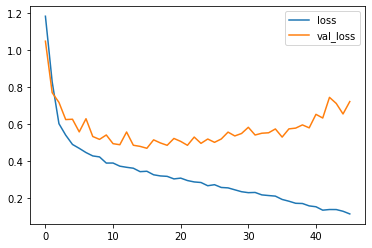

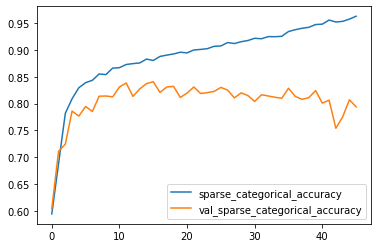

In [28]:
# create learning curves to evaluate model performance
#history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot();

# Some conclusions

The maximum sparse_categorical_accuracy = 0.9627

The maximum val_sparse_categorical_accuracy = 0.8406 
    
Which is not bad without balancing the data but we have also augmentation on the fly

we have some over fitting on the trained model and also it predicts the test photo wrong

In [29]:
# this code will convert our test image data to a float32 
def to_float32(image, label):
    return tf.cast(image, tf.float32), label

# predict the test photo

In [30]:
test_ds = get_test_dataset(ordered=True) 
test_ds = test_ds.map(to_float32)

print('Computing predictions...')
##test_images_ds = get_test_dataset()
test_images_ds = test_ds.map(lambda image, idnum: image)
probabilities = model.predict(test_images_ds)
predictions = np.argmax(probabilities, axis=-1)
print(predictions)

Computing predictions...
[4]


# Getting the test label in a list 

In [31]:
# load our validation dataset labels
y_test = []
##x_test = []

validation_dataset = get_validation_dataset()
validation_dataset = validation_dataset.unbatch()##.batch(1)
for image, label in validation_dataset:
    ##x_test.append(image.numpy())
    y_test.append(label.numpy())
    


In [ ]:
y_test

# Getting the length of the test labels to make sure of there numbers

In [33]:
len(y_test)

2676

# Brief exploratory data analysis (EDA)
First we'll print out the shapes and labels for a sample of each of our three datasets:

In [ ]:
'''
print("Training data shapes:")
for image, label in get_training_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training data label examples:", label.numpy())
print("Validation data shapes:")
for image, label in get_validation_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Validation data label examples:", label.numpy())
print("Test data shapes:")
for image, idnum in get_test_dataset().take(3):
    print(image.numpy().shape, idnum.numpy().shape)
print("Test data IDs:", idnum.numpy().astype('U')) # U=unicode string
'''

# Getting the prediction of the validation set

In [34]:
validation_dataset = get_validation_dataset()

probabilities = model.predict(validation_dataset)
predictions = np.argmax(probabilities, axis=-1)

print(predictions)

[3 1 2 ... 3 0 3]


In [56]:
'''
def get_train_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)  

    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

'''

In [57]:
'''
train_dataset = get_train_dataset()

train_probabilities = model.predict(train_dataset)
train_predictions = np.argmax(train_probabilities, axis=-1)

print(train_predictions)
'''

[3 1 4 ... 3 4 4]


In [58]:
'''
# load our validation dataset for EDA
y_train = []
##x_test = []

train_dataset = get_train_dataset()
train_dataset = train_dataset.unbatch()##.batch(1)
for image, label in train_dataset:
    ##x_test.append(image.numpy())
    y_train.append(label.numpy())
'''

In [59]:
##len(y_train)

16045

# Some libraries for plotting

In [35]:
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Plotting the confusion Matrix

Calculating the Recall and the Precision (Calculated manually after getting the concept for multicalasses classification)


In [36]:
from sklearn.metrics import confusion_matrix



def plot_cm(labels, predictions):
      cm = confusion_matrix(labels, predictions)
      print(cm)
      plt.figure(figsize=(5,5))
      sns.heatmap(cm, annot=True, fmt="d")
      plt.title('Confusion matrix')
      plt.ylabel('Actual label')
      plt.xlabel('Predicted label')


      rows = np.sum(cm, axis = 1) 
      cols = np.sum(cm, axis = 0) 
      recall_labels = []
      Precision_labels = []

      for i in range(len(CLASSES)):
        recall_labels.append(cm[i][i]/rows[i])
        Precision_labels.append(cm[i][i]/cols[i])
        
      print('recall labels = ')
      print(recall_labels)
      print("")
    
      print('Precision labels = ')
      print(Precision_labels)
      print("")

      MACRO_AVERAGING_Recall = np.sum(recall_labels)/len(CLASSES)
      MACRO_AVERAGING_Precision = np.sum(Precision_labels)/len(CLASSES)

      print('MACRO AVERAGING Recall = ')
      print(MACRO_AVERAGING_Recall)
      print("")
    
      print('MACRO AVERAGING Precision = ')
      print(MACRO_AVERAGING_Precision)
      print("")
        
  



'''
labels = [0, 1, 2, 3, 4]

cm = confusion_matrix(y_test, predictions)

print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
'''

"\nlabels = [0, 1, 2, 3, 4]\n\ncm = confusion_matrix(y_test, predictions)\n\nprint(cm)\nfig = plt.figure()\nax = fig.add_subplot(111)\ncax = ax.matshow(cm)\nplt.title('Confusion matrix of the classifier')\nfig.colorbar(cax)\nax.set_xticklabels([''] + labels)\nax.set_yticklabels([''] + labels)\nplt.xlabel('Predicted')\nplt.ylabel('True')\nplt.show()\n"

[[   9   11   12   65   28]
 [  17   27   19  161   54]
 [  19   31   30  173   64]
 [  92  147  139 1012  235]
 [  23   29   27  190   62]]
recall labels = 
[0.072, 0.09712230215827339, 0.0946372239747634, 0.6227692307692307, 0.18731117824773413]

Precision labels = 
[0.05625, 0.11020408163265306, 0.13215859030837004, 0.63210493441599, 0.1399548532731377]

MACRO AVERAGING Recall = 
0.21476798703000033

MACRO AVERAGING Precision = 
0.21413449192603018



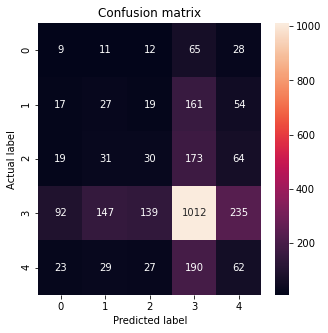

In [37]:
plot_cm(y_test, predictions)

In [89]:
##manually getting the Precision and recall but we put them up in the function of plot cm
'''
rows = np.sum(cm, axis = 1) 
cols = np.sum(cm, axis = 0) 
recall_labels = []
Precision_labels = []

for i in range(len(CLASSES)):
    recall_labels.append(cm[i][i]/rows[i])
    Precision_labels.append(cm[i][i]/cols[i])
    
print(recall_labels)
print(Precision_labels)

MACRO_AVERAGING_Recall = np.sum(recall_labels)/len(CLASSES)
MACRO_AVERAGING_Precision = np.sum(Precision_labels)/len(CLASSES)

print(MACRO_AVERAGING_Recall)
print(MACRO_AVERAGING_Precision)
'''


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in long_scalars
  


# Plotting the ROC Curve

1st trying for Binary classification

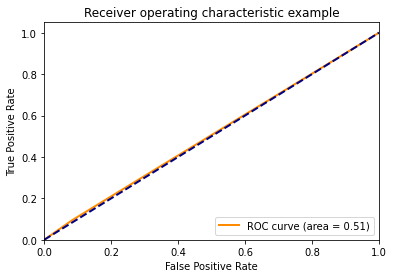

In [40]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing  import label_binarize
# from scipy import interp

n_classes = len(CLASSES)

# Binarize the output 
true_labels_l_b = label_binarize(y_test, classes=range(n_classes))
# Y_pred_b = label_binarize(Y_pred, classes=CLASSES)
Y_pred_b = label_binarize(predictions, classes=range(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels_l_b[:,i], Y_pred_b[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(true_labels_l_b.ravel(), Y_pred_b.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])



#Plot of a ROC curve for a specific class

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# 2nd  or multiclasses classification

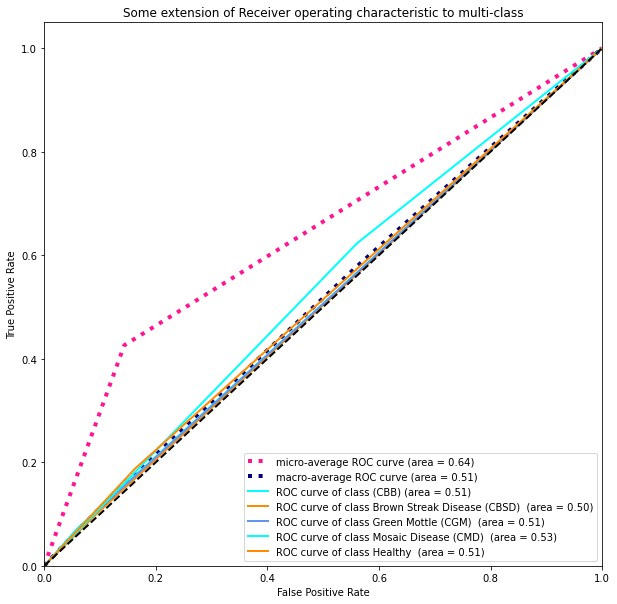

In [41]:
import itertools

target_names = ['(CBB)','Brown Streak Disease (CBSD) ','Green Mottle (CGM) ','Mosaic Disease (CMD) ','Healthy ']

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize = (10,10))

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = itertools.cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(target_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# Parameters that will be changed during comparisons

# Case 2 :

Transfer layer VGG19

The parameters are Tunable (trainable = True) 

Fixed learning rate


In [42]:

from keras.applications.vgg19 import preprocess_input

#tf.keras.applications.vgg19.preprocess_input


with strategy.scope():       
    ##img_adjust_layer = tf.keras.layers.Lambda(tf.keras.applications.vgg16.preprocess_input, input_shape=[512,512, 3])
    
    base_model = tf.keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_tensor= None,
    input_shape=[512,512, 3],
    pooling=None,
    classes=5,
    classifier_activation="softmax")
    
    base_model.trainable = True
    
    
    model = tf.keras.Sequential([
        tf.keras.layers.BatchNormalization(renorm=True),
        ##img_adjust_layer,
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=4096,activation="relu"),
        tf.keras.layers.Dense(units=4096,activation="relu"),
        tf.keras.layers.Dense(units=1000,activation="relu"),
        tf.keras.layers.Dense(units=500,activation="relu"),
        tf.keras.layers.Dense(units=100,activation="relu"),
        tf.keras.layers.Dense(units=5, activation="softmax") 
        
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, epsilon=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'])
        

'''
        metrics2=['categorical_accuracy',
                           tf.keras.metrics.Precision(name='Precision'),
                           tf.keras.metrics.Recall(name='Recall')])
                           
                           'sparse_categorical_accuracy'
                           metrics=['sparse_categorical_accuracy'])
                            metrics=['sparse_categorical_accuracy',tf.keras.metrics.AUC()])
'''

"\n        metrics2=['categorical_accuracy',\n                           tf.keras.metrics.Precision(name='Precision'),\n                           tf.keras.metrics.Recall(name='Recall')])\n                           \n                           'sparse_categorical_accuracy'\n                           metrics=['sparse_categorical_accuracy'])\n                            metrics=['sparse_categorical_accuracy',tf.keras.metrics.AUC()])\n"

In [43]:
# load data
train_dataset = get_training_dataset()
valid_dataset = get_validation_dataset()

In [55]:
from keras.callbacks import CSVLogger

##csv_logger = CSVLogger('training.log', separator=',', append=False)


In [45]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

keras_callbacks   = [EarlyStopping(monitor='val_loss', patience=30, mode='min', min_delta=0.0001),
    ModelCheckpoint('mymodel.h5', monitor='val_loss', verbose=1,
    save_best_only=True, save_weights_only=True, mode='auto', period=1),
    CSVLogger('training.log', separator=',', append=False)
    
]

##save_best_only=True

In [46]:
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
VALID_STEPS = NUM_VALIDATION_IMAGES // BATCH_SIZE

history = model.fit(train_dataset, 
                    steps_per_epoch=STEPS_PER_EPOCH, 
                    epochs=EPOCHS,
                    validation_data=valid_dataset,
                    validation_steps=VALID_STEPS,
                    callbacks=keras_callbacks)
                   

##model.save('mymodel.h5')

Epoch 1/300
146/146 [==============================] - ETA: 0s - loss: 0.9714 - sparse_categorical_accuracy: 0.6438
Epoch 00001: val_loss improved from inf to 1.04248, saving model to mymodel.h5
146/146 [==============================] - 68s 466ms/step - loss: 0.9714 - sparse_categorical_accuracy: 0.6438 - val_loss: 1.0425 - val_sparse_categorical_accuracy: 0.6270
Epoch 2/300
146/146 [==============================] - ETA: 0s - loss: 0.7117 - sparse_categorical_accuracy: 0.7360
Epoch 00002: val_loss improved from 1.04248 to 0.54454, saving model to mymodel.h5
146/146 [==============================] - 58s 394ms/step - loss: 0.7117 - sparse_categorical_accuracy: 0.7360 - val_loss: 0.5445 - val_sparse_categorical_accuracy: 0.8074
Epoch 3/300
146/146 [==============================] - ETA: 0s - loss: 0.5122 - sparse_categorical_accuracy: 0.8219
Epoch 00003: val_loss improved from 0.54454 to 0.48599, saving model to mymodel.h5
146/146 [==============================] - 58s 394ms/step - los

In [47]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch multiple                  21        
_________________________________________________________________
vgg19 (Model)                (None, 16, 16, 512)       20024384  
_________________________________________________________________
global_average_pooling2d_1 ( multiple                  0         
_________________________________________________________________
flatten_1 (Flatten)          multiple                  0         
_________________________________________________________________
dense_6 (Dense)              multiple                  2101248   
_________________________________________________________________
dense_7 (Dense)              multiple                  16781312  
_________________________________________________________________
dense_8 (Dense)              multiple                 

In [48]:
model.save('model2_VGG19_untunable.h5')
model.save('model3_VGG19_untunable.hdf5')

In [49]:
## load the history data if we stopped the model suddenly 

#log_data = pd.read_csv('training.log', sep=',', engine='python')


In [50]:
##model2 = tf.keras.models.load_model('../input/testmodel2/model2_VGG19_untunable.h5')

In [51]:
##model.save('model2.h5')

In [52]:
##model.save('model.hdf5')

In [53]:
## load the history data if we stopped the model suddenly 

history_frame = pd.read_csv('training.log', sep=',', engine='python')


##history_frame = pd.read_csv('../input/testmodel2/training.log', sep=',', engine='python')

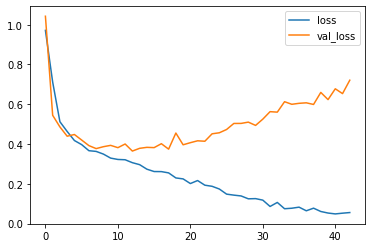

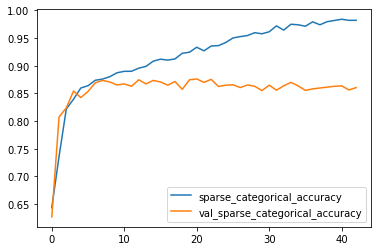

In [54]:
# create learning curves to evaluate model performance
#history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot();

# Some conclusions

The maximum sparse_categorical_accuracy around = 0.98

The maximum val_sparse_categorical_accuracy around = 0.87
    
Which is not bad without balancing the data but we have also augmentation on the fly

we have some over fitting on the trained model and also it predicts the test photo wrong

But the validation accuracy increased this time compared to the above results

In [56]:
# this code will convert our test image data to a float32 
def to_float32(image, label):
    return tf.cast(image, tf.float32), label

In [57]:
test_ds = get_test_dataset(ordered=True) 
test_ds = test_ds.map(to_float32)

print('Computing predictions...')
##test_images_ds = get_test_dataset()
test_images_ds = test_ds.map(lambda image, idnum: image)
probabilities = model.predict(test_images_ds)
predictions = np.argmax(probabilities, axis=-1)
print(predictions)

Computing predictions...
[4]


In [58]:
# load our validation dataset labels
y_test = []
##x_test = []

validation_dataset = get_validation_dataset()
validation_dataset = validation_dataset.unbatch()##.batch(1)
for image, label in validation_dataset:
    ##x_test.append(image.numpy())
    y_test.append(label.numpy())
    


In [ ]:
y_test

In [60]:
len(y_test)

2676

In [61]:
'''
print("Training data shapes:")
for image, label in get_training_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training data label examples:", label.numpy())
print("Validation data shapes:")
for image, label in get_validation_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Validation data label examples:", label.numpy())
print("Test data shapes:")
for image, idnum in get_test_dataset().take(3):
    print(image.numpy().shape, idnum.numpy().shape)
print("Test data IDs:", idnum.numpy().astype('U')) # U=unicode string
'''

'\nprint("Training data shapes:")\nfor image, label in get_training_dataset().take(3):\n    print(image.numpy().shape, label.numpy().shape)\nprint("Training data label examples:", label.numpy())\nprint("Validation data shapes:")\nfor image, label in get_validation_dataset().take(3):\n    print(image.numpy().shape, label.numpy().shape)\nprint("Validation data label examples:", label.numpy())\nprint("Test data shapes:")\nfor image, idnum in get_test_dataset().take(3):\n    print(image.numpy().shape, idnum.numpy().shape)\nprint("Test data IDs:", idnum.numpy().astype(\'U\')) # U=unicode string\n'

In [62]:
validation_dataset = get_validation_dataset()

probabilities = model.predict(validation_dataset)
predictions = np.argmax(probabilities, axis=-1)

print(predictions)

[3 1 2 ... 3 1 3]


In [ ]:
'''
def get_train_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)  

    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

'''

In [ ]:
'''
train_dataset = get_train_dataset()

train_probabilities = model.predict(train_dataset)
train_predictions = np.argmax(train_probabilities, axis=-1)

print(train_predictions)
'''

In [ ]:
'''
# load our validation dataset for EDA
y_train = []
##x_test = []

train_dataset = get_train_dataset()
train_dataset = train_dataset.unbatch()##.batch(1)
for image, label in train_dataset:
    ##x_test.append(image.numpy())
    y_train.append(label.numpy())
'''

In [ ]:
##len(y_train)

In [63]:
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [64]:
from sklearn.metrics import confusion_matrix



def plot_cm(labels, predictions):
      cm = confusion_matrix(labels, predictions)
      print(cm)
      plt.figure(figsize=(5,5))
      sns.heatmap(cm, annot=True, fmt="d")
      plt.title('Confusion matrix')
      plt.ylabel('Actual label')
      plt.xlabel('Predicted label')


      rows = np.sum(cm, axis = 1) 
      cols = np.sum(cm, axis = 0) 
      recall_labels = []
      Precision_labels = []

      for i in range(len(CLASSES)):
        recall_labels.append(cm[i][i]/rows[i])
        Precision_labels.append(cm[i][i]/cols[i])
        
      print('recall labels = ')
      print(recall_labels)
      print("")
    
      print('Precision labels = ')
      print(Precision_labels)
      print("")

      MACRO_AVERAGING_Recall = np.sum(recall_labels)/len(CLASSES)
      MACRO_AVERAGING_Precision = np.sum(Precision_labels)/len(CLASSES)

      print('MACRO AVERAGING Recall = ')
      print(MACRO_AVERAGING_Recall)
      print("")
    
      print('MACRO AVERAGING Precision = ')
      print(MACRO_AVERAGING_Precision)
      print("")
        
  



'''
labels = [0, 1, 2, 3, 4]

cm = confusion_matrix(y_test, predictions)

print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
'''

"\nlabels = [0, 1, 2, 3, 4]\n\ncm = confusion_matrix(y_test, predictions)\n\nprint(cm)\nfig = plt.figure()\nax = fig.add_subplot(111)\ncax = ax.matshow(cm)\nplt.title('Confusion matrix of the classifier')\nfig.colorbar(cax)\nax.set_xticklabels([''] + labels)\nax.set_yticklabels([''] + labels)\nplt.xlabel('Predicted')\nplt.ylabel('True')\nplt.show()\n"

[[  20   12   10   64   19]
 [  15   55   20  160   28]
 [  10   23   79  180   25]
 [  66  119  132 1169  139]
 [  21   39   42  158   71]]
recall labels = 
[0.16, 0.19784172661870503, 0.24921135646687698, 0.7193846153846154, 0.21450151057401812]

Precision labels = 
[0.15151515151515152, 0.2217741935483871, 0.2791519434628975, 0.6753321779318313, 0.25177304964539005]

MACRO AVERAGING Recall = 
0.3081878418088431

MACRO AVERAGING Precision = 
0.3159093032207315



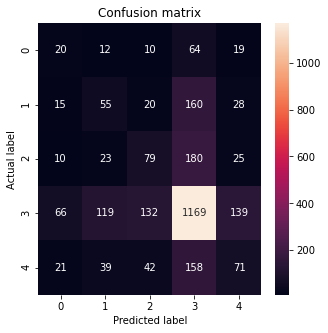

In [65]:
plot_cm(y_test, predictions)

In [66]:
##manually getting the Precision and recall but we but them up in the function of plot cm
'''
rows = np.sum(cm, axis = 1) 
cols = np.sum(cm, axis = 0) 
recall_labels = []
Precision_labels = []

for i in range(len(CLASSES)):
    recall_labels.append(cm[i][i]/rows[i])
    Precision_labels.append(cm[i][i]/cols[i])
    
print(recall_labels)
print(Precision_labels)

MACRO_AVERAGING_Recall = np.sum(recall_labels)/len(CLASSES)
MACRO_AVERAGING_Precision = np.sum(Precision_labels)/len(CLASSES)

print(MACRO_AVERAGING_Recall)
print(MACRO_AVERAGING_Precision)
'''


'\nrows = np.sum(cm, axis = 1) \ncols = np.sum(cm, axis = 0) \nrecall_labels = []\nPrecision_labels = []\n\nfor i in range(len(CLASSES)):\n    recall_labels.append(cm[i][i]/rows[i])\n    Precision_labels.append(cm[i][i]/cols[i])\n    \nprint(recall_labels)\nprint(Precision_labels)\n\nMACRO_AVERAGING_Recall = np.sum(recall_labels)/len(CLASSES)\nMACRO_AVERAGING_Precision = np.sum(Precision_labels)/len(CLASSES)\n\nprint(MACRO_AVERAGING_Recall)\nprint(MACRO_AVERAGING_Precision)\n'

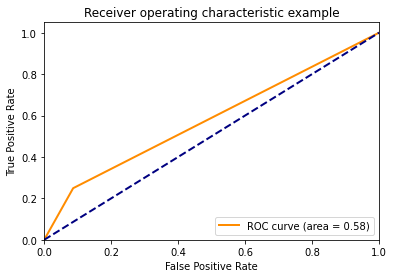

In [69]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing  import label_binarize
# from scipy import interp

n_classes = len(CLASSES)

# Binarize the output 
true_labels_l_b = label_binarize(y_test, classes=range(n_classes))
# Y_pred_b = label_binarize(Y_pred, classes=CLASSES)
Y_pred_b = label_binarize(predictions, classes=range(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels_l_b[:,i], Y_pred_b[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(true_labels_l_b.ravel(), Y_pred_b.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])



#Plot of a ROC curve for a specific class

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

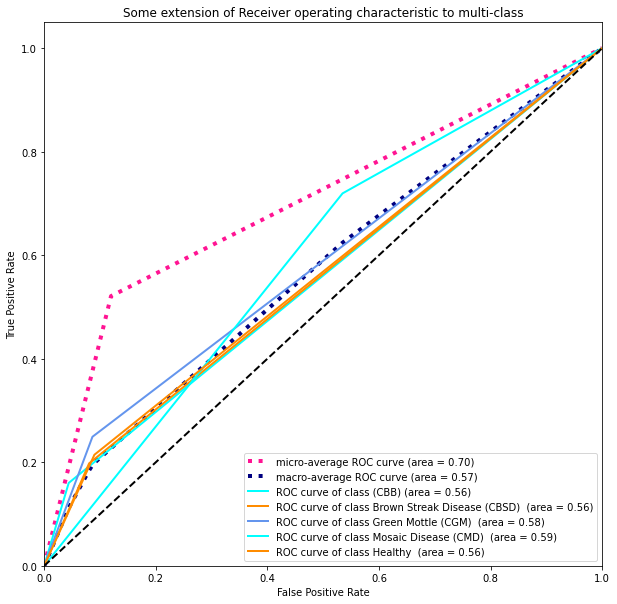

In [70]:
import itertools

target_names = ['(CBB)','Brown Streak Disease (CBSD) ','Green Mottle (CGM) ','Mosaic Disease (CMD) ','Healthy ']

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize = (10,10))

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = itertools.cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(target_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# Parameters that will be changed during comparisons

# Case 3 :

Transfer layer VGG19

The parameters are untunable (trainable = False) 

Fixed learning rate


In [17]:

from keras.applications.vgg19 import preprocess_input

#tf.keras.applications.vgg19.preprocess_input


with strategy.scope():       
    ##img_adjust_layer = tf.keras.layers.Lambda(tf.keras.applications.vgg16.preprocess_input, input_shape=[512,512, 3])
    
    base_model = tf.keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_tensor= None,
    input_shape=[512,512, 3],
    pooling=None,
    classes=5,
    classifier_activation="softmax")
    
    base_model.trainable = False
    
    
    model = tf.keras.Sequential([
        tf.keras.layers.BatchNormalization(renorm=True),
        ##img_adjust_layer,
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=4096,activation="relu"),
        tf.keras.layers.Dense(units=4096,activation="relu"),
        tf.keras.layers.Dense(units=1000,activation="relu"),
        tf.keras.layers.Dense(units=500,activation="relu"),
        tf.keras.layers.Dense(units=100,activation="relu"),
        tf.keras.layers.Dense(units=5, activation="softmax") 
        
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01, epsilon=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'])
        

'''
        metrics2=['categorical_accuracy',
                           tf.keras.metrics.Precision(name='Precision'),
                           tf.keras.metrics.Recall(name='Recall')])
                           
                           'sparse_categorical_accuracy'
                           metrics=['sparse_categorical_accuracy'])
                            metrics=['sparse_categorical_accuracy',tf.keras.metrics.AUC()])
'''

80142336/80134624 [==============================] - 1s 0us/step


"\n        metrics2=['categorical_accuracy',\n                           tf.keras.metrics.Precision(name='Precision'),\n                           tf.keras.metrics.Recall(name='Recall')])\n                           \n                           'sparse_categorical_accuracy'\n                           metrics=['sparse_categorical_accuracy'])\n                            metrics=['sparse_categorical_accuracy',tf.keras.metrics.AUC()])\n"

In [18]:
# load data
train_dataset = get_training_dataset()
valid_dataset = get_validation_dataset()

In [19]:
from keras.callbacks import CSVLogger

##csv_logger = CSVLogger('training.log', separator=',', append=False)


In [20]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

keras_callbacks   = [EarlyStopping(monitor='val_loss', patience=30, mode='min', min_delta=0.0001),
    ModelCheckpoint('mymodel.h5', monitor='val_loss', verbose=1,
    save_best_only=True, save_weights_only=True, mode='auto', period=1),
    CSVLogger('training.log', separator=',', append=False)
    
]

##save_best_only=True

In [21]:
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
VALID_STEPS = NUM_VALIDATION_IMAGES // BATCH_SIZE

history = model.fit(train_dataset, 
                    steps_per_epoch=STEPS_PER_EPOCH, 
                    epochs=EPOCHS,
                    validation_data=valid_dataset,
                    validation_steps=VALID_STEPS,
                    callbacks=keras_callbacks)
                   

##model.save('mymodel.h5')

Epoch 1/300
146/146 [==============================] - ETA: 0s - loss: 1.0153 - sparse_categorical_accuracy: 0.6330
Epoch 00001: val_loss improved from inf to 0.85777, saving model to mymodel.h5
146/146 [==============================] - 52s 359ms/step - loss: 1.0153 - sparse_categorical_accuracy: 0.6330 - val_loss: 0.8578 - val_sparse_categorical_accuracy: 0.6687
Epoch 2/300
146/146 [==============================] - ETA: 0s - loss: 0.8541 - sparse_categorical_accuracy: 0.6722
Epoch 00002: val_loss improved from 0.85777 to 0.81595, saving model to mymodel.h5
146/146 [==============================] - 41s 284ms/step - loss: 0.8541 - sparse_categorical_accuracy: 0.6722 - val_loss: 0.8160 - val_sparse_categorical_accuracy: 0.6742
Epoch 3/300
146/146 [==============================] - ETA: 0s - loss: 0.8107 - sparse_categorical_accuracy: 0.6881
Epoch 00003: val_loss improved from 0.81595 to 0.79560, saving model to mymodel.h5
146/146 [==============================] - 42s 285ms/step - los

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo multiple                  21        
_________________________________________________________________
vgg19 (Model)                (None, 16, 16, 512)       20024384  
_________________________________________________________________
global_average_pooling2d (Gl multiple                  0         
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  2101248   
_________________________________________________________________
dense_1 (Dense)              multiple                  16781312  
_________________________________________________________________
dense_2 (Dense)              multiple                  4

In [23]:
model.save('model2_VGG19_untunable.h5')
model.save('model3_VGG19_untunable.hdf5')

In [ ]:
## load the history data if we stopped the model suddenly 

#log_data = pd.read_csv('training.log', sep=',', engine='python')


In [ ]:
##model2 = tf.keras.models.load_model('../input/testmodel2/model2_VGG19_untunable.h5')

In [ ]:
##model.save('model2.h5')

In [ ]:
##model.save('model.hdf5')

In [24]:
## load the history data if we stopped the model suddenly 

history_frame = pd.read_csv('training.log', sep=',', engine='python')


##history_frame = pd.read_csv('../input/testmodel2/training.log', sep=',', engine='python')

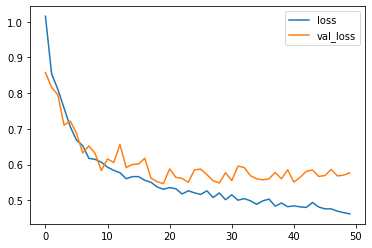

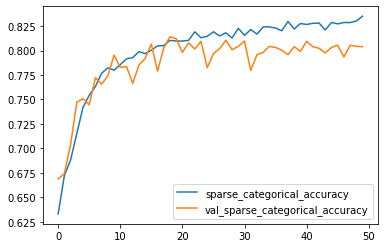

In [25]:
# create learning curves to evaluate model performance
#history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot();

# Some conclusions

The maximum sparse_categorical_accuracy = 0.83

The maximum val_sparse_categorical_accuracy = 0.81 
    
Which is not bad without balancing the data but we have also augmentation on the fly

In this case , this time there is no over fitting in the trained model, the training accuracy and the validation one are close to each other. But the over all performance is not that good and need to be enhanced using balancing and filltering the dataset, also it predicts the test photo wrong




In [26]:
# this code will convert our test image data to a float32 
def to_float32(image, label):
    return tf.cast(image, tf.float32), label

In [27]:
test_ds = get_test_dataset(ordered=True) 
test_ds = test_ds.map(to_float32)

print('Computing predictions...')
##test_images_ds = get_test_dataset()
test_images_ds = test_ds.map(lambda image, idnum: image)
probabilities = model.predict(test_images_ds)
predictions = np.argmax(probabilities, axis=-1)
print(predictions)

Computing predictions...
[4]


In [28]:
# load our validation dataset labels
y_test = []
##x_test = []

validation_dataset = get_validation_dataset()
validation_dataset = validation_dataset.unbatch()##.batch(1)
for image, label in validation_dataset:
    ##x_test.append(image.numpy())
    y_test.append(label.numpy())
    


In [ ]:
y_test

In [30]:
len(y_test)

2676

In [31]:
'''
print("Training data shapes:")
for image, label in get_training_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training data label examples:", label.numpy())
print("Validation data shapes:")
for image, label in get_validation_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Validation data label examples:", label.numpy())
print("Test data shapes:")
for image, idnum in get_test_dataset().take(3):
    print(image.numpy().shape, idnum.numpy().shape)
print("Test data IDs:", idnum.numpy().astype('U')) # U=unicode string
'''

'\nprint("Training data shapes:")\nfor image, label in get_training_dataset().take(3):\n    print(image.numpy().shape, label.numpy().shape)\nprint("Training data label examples:", label.numpy())\nprint("Validation data shapes:")\nfor image, label in get_validation_dataset().take(3):\n    print(image.numpy().shape, label.numpy().shape)\nprint("Validation data label examples:", label.numpy())\nprint("Test data shapes:")\nfor image, idnum in get_test_dataset().take(3):\n    print(image.numpy().shape, idnum.numpy().shape)\nprint("Test data IDs:", idnum.numpy().astype(\'U\')) # U=unicode string\n'

In [32]:
validation_dataset = get_validation_dataset()

probabilities = model.predict(validation_dataset)
predictions = np.argmax(probabilities, axis=-1)

print(predictions)

[3 1 2 ... 3 0 3]


In [ ]:
'''
def get_train_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)  

    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

'''

In [ ]:
'''
train_dataset = get_train_dataset()

train_probabilities = model.predict(train_dataset)
train_predictions = np.argmax(train_probabilities, axis=-1)

print(train_predictions)
'''

In [ ]:
'''
# load our validation dataset for EDA
y_train = []
##x_test = []

train_dataset = get_train_dataset()
train_dataset = train_dataset.unbatch()##.batch(1)
for image, label in train_dataset:
    ##x_test.append(image.numpy())
    y_train.append(label.numpy())
'''

In [ ]:
##len(y_train)

In [33]:
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [34]:
from sklearn.metrics import confusion_matrix



def plot_cm(labels, predictions):
      cm = confusion_matrix(labels, predictions)
      print(cm)
      plt.figure(figsize=(5,5))
      sns.heatmap(cm, annot=True, fmt="d")
      plt.title('Confusion matrix')
      plt.ylabel('Actual label')
      plt.xlabel('Predicted label')


      rows = np.sum(cm, axis = 1) 
      cols = np.sum(cm, axis = 0) 
      recall_labels = []
      Precision_labels = []

      for i in range(len(CLASSES)):
        recall_labels.append(cm[i][i]/rows[i])
        Precision_labels.append(cm[i][i]/cols[i])
        
      print('recall labels = ')
      print(recall_labels)
      print("")
    
      print('Precision labels = ')
      print(Precision_labels)
      print("")

      MACRO_AVERAGING_Recall = np.sum(recall_labels)/len(CLASSES)
      MACRO_AVERAGING_Precision = np.sum(Precision_labels)/len(CLASSES)

      print('MACRO AVERAGING Recall = ')
      print(MACRO_AVERAGING_Recall)
      print("")
    
      print('MACRO AVERAGING Precision = ')
      print(MACRO_AVERAGING_Precision)
      print("")
        
  



'''
labels = [0, 1, 2, 3, 4]

cm = confusion_matrix(y_test, predictions)

print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
'''

"\nlabels = [0, 1, 2, 3, 4]\n\ncm = confusion_matrix(y_test, predictions)\n\nprint(cm)\nfig = plt.figure()\nax = fig.add_subplot(111)\ncax = ax.matshow(cm)\nplt.title('Confusion matrix of the classifier')\nfig.colorbar(cax)\nax.set_xticklabels([''] + labels)\nax.set_yticklabels([''] + labels)\nplt.xlabel('Predicted')\nplt.ylabel('True')\nplt.show()\n"

[[   2   20   11   82   10]
 [  12   39   31  162   34]
 [  11   30   29  195   52]
 [  80  175  141 1001  228]
 [  15   38   24  202   52]]
recall labels = 
[0.016, 0.14028776978417265, 0.0914826498422713, 0.616, 0.15709969788519637]

Precision labels = 
[0.016666666666666666, 0.1291390728476821, 0.1228813559322034, 0.6096224116930572, 0.13829787234042554]

MACRO AVERAGING Recall = 
0.20417402350232808

MACRO AVERAGING Precision = 
0.203321475896007



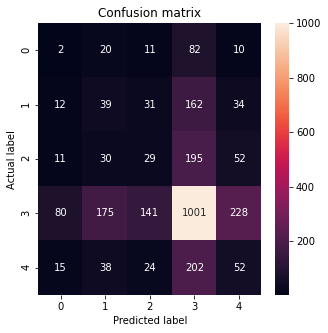

In [35]:
plot_cm(y_test, predictions)

In [ ]:
##manually getting the Precision and recall but we but them up in the function of plot cm
'''
rows = np.sum(cm, axis = 1) 
cols = np.sum(cm, axis = 0) 
recall_labels = []
Precision_labels = []

for i in range(len(CLASSES)):
    recall_labels.append(cm[i][i]/rows[i])
    Precision_labels.append(cm[i][i]/cols[i])
    
print(recall_labels)
print(Precision_labels)

MACRO_AVERAGING_Recall = np.sum(recall_labels)/len(CLASSES)
MACRO_AVERAGING_Precision = np.sum(Precision_labels)/len(CLASSES)

print(MACRO_AVERAGING_Recall)
print(MACRO_AVERAGING_Precision)
'''


In [36]:
def plot_roc(name, labels, predictions, **kwargs):
  fp[i], tp[i], _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

In [37]:
plot_roc("Train Baseline", y_train, train_predictions)
plot_roc("Test Baseline", y_test, predictions, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

NameError: name 'y_train' is not defined

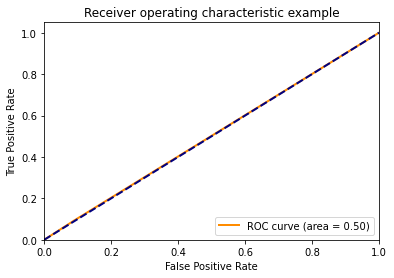

In [38]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing  import label_binarize
# from scipy import interp

n_classes = len(CLASSES)

# Binarize the output 
true_labels_l_b = label_binarize(y_test, classes=range(n_classes))
# Y_pred_b = label_binarize(Y_pred, classes=CLASSES)
Y_pred_b = label_binarize(predictions, classes=range(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels_l_b[:,i], Y_pred_b[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(true_labels_l_b.ravel(), Y_pred_b.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])



#Plot of a ROC curve for a specific class

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

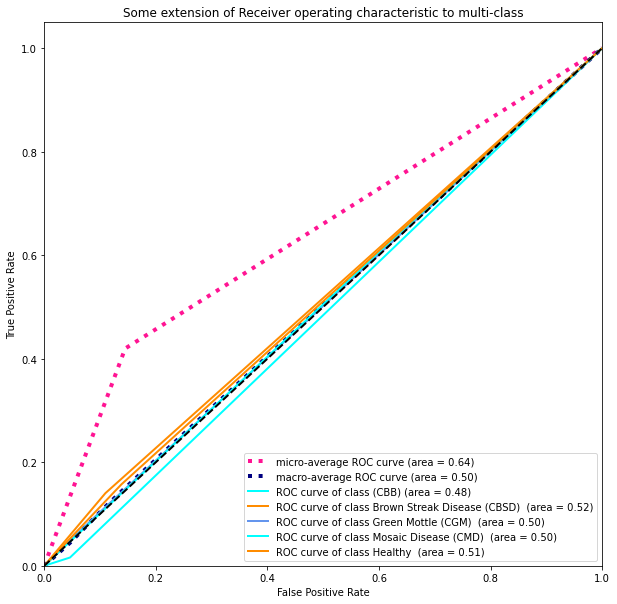

In [39]:
import itertools

target_names = ['(CBB)','Brown Streak Disease (CBSD) ','Green Mottle (CGM) ','Mosaic Disease (CMD) ','Healthy ']

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize = (10,10))

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = itertools.cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(target_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()